<a href="https://colab.research.google.com/github/jasonyang429/CNN-for-CIFAR100/blob/main/Cifar100_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.datasets import cifar100
print(tf.__version__)

2.3.0


In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

x_train = x_train/255.
x_test = x_test/255.

y_train_oh = tf.keras.utils.to_categorical(y_train)
y_test_oh = tf.keras.utils.to_categorical(y_test)
## try to use 0.95 for split later
split = int(0.95 * len(x_train))
x_val = x_train[split:]
y_val_oh = y_train_oh[split:]
x_train = x_train[:split]
y_train_oh = y_train_oh[:split]

print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Test set size:", len(x_test))
print("Number of classes:", len(np.unique(y_train)))
print("Input shape:", x_train.shape)

169009152/169001437 [==============================] - 4s 0us/step
Training set size: 47500
Validation set size: 2500
Test set size: 10000
Number of classes: 100
Input shape: (47500, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: This function is deprecated. Please call randint(0, 47499 + 1) instead


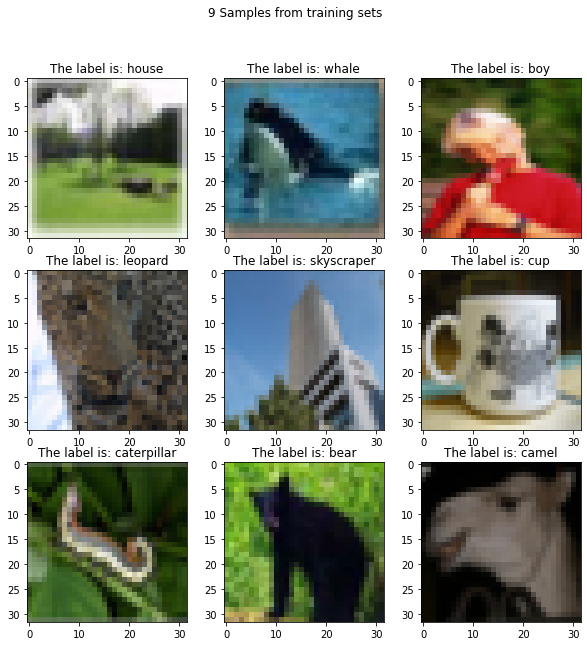

In [3]:
def label_name(label):
  labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

  return labels[label]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    random_img = np.random.random_integers(0, split-1)
    plt.sca(ax)
    plt.imshow(x_train[random_img], cmap=plt.get_cmap())
    plt.title('The label is: {}'.format(label_name(int(y_train[random_img]))))

plt.suptitle('9 Samples from training sets')
plt.show()

In [4]:
def create_model():
  model = tf.keras.Sequential([
          tf.keras.layers.Conv2D(64, (3,3), 1, input_shape=(32,32,3)),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Dropout(0.25),
          tf.keras.layers.Conv2D(128, (3,3), 1, activation='relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Dropout(0.35),
          tf.keras.layers.Conv2D(256, (3,3), 1, activation='relu'),
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'),
          tf.keras.layers.Dropout(0.2),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(0.1),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dense(100, activation='softmax')
  ])
  
  return model

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         2

In [5]:
# checkpoint_path = "training/cp-{epoch：04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# checkpoint_callbacks = tf.keras.callbacks.ModelCheckpoint(
#                         filepath=checkpoint_dir,
#                         verbose=1,
#                         save_weights_only=True
# )

datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

### Load the model weights
# model.load_weights(checkpoint_path)

model.compile(optimizer=tf.keras.optimizers.SGD(0.12, momentum=0.9, nesterov=True, decay=1e-3), loss='categorical_crossentropy', 
              metrics=['accuracy'])
## ~41% train & val accuracy with SGD(0.1, momentum=0.9, nesterov=True, decay=1e-3)
## ~45% train & val accuracy with SGD(0.09, momentum=0.9, nesterov=True, decay=1e-3) and stop lr decay after 5 epochs
def scheduler(epochs, lr):
  decay = 1e-3
  if epochs < 5:
    lr = lr * (1./1. + decay * epochs)
  return lr

history = model.fit(datagen.flow(x_train, y_train_oh, batch_size=batch_size),
                     epochs=100, steps_per_epoch=x_train.shape[0]/batch_size,
                    verbose=2, validation_data=(x_val, y_val_oh))
 #                   callbacks=[tf.keras.callbacks.LearningRateScheduler(scheduler)])
 #                   ,callbacks=[checkpoint_callbacks]

Epoch 1/100
1485/1484 - 23s - loss: 4.4842 - accuracy: 0.0189 - val_loss: 4.2759 - val_accuracy: 0.0356
Epoch 2/100
1485/1484 - 22s - loss: 4.1359 - accuracy: 0.0530 - val_loss: 3.9340 - val_accuracy: 0.0732
Epoch 3/100
1485/1484 - 22s - loss: 3.9197 - accuracy: 0.0856 - val_loss: 3.7160 - val_accuracy: 0.1236
Epoch 4/100
1485/1484 - 22s - loss: 3.7525 - accuracy: 0.1157 - val_loss: 3.5910 - val_accuracy: 0.1456
Epoch 5/100
1485/1484 - 22s - loss: 3.6198 - accuracy: 0.1360 - val_loss: 3.4623 - val_accuracy: 0.1624
Epoch 6/100
1485/1484 - 22s - loss: 3.5121 - accuracy: 0.1588 - val_loss: 3.2922 - val_accuracy: 0.2008
Epoch 7/100
1485/1484 - 22s - loss: 3.4190 - accuracy: 0.1725 - val_loss: 3.2095 - val_accuracy: 0.2064
Epoch 8/100
1485/1484 - 22s - loss: 3.3424 - accuracy: 0.1865 - val_loss: 3.1339 - val_accuracy: 0.2200
Epoch 9/100
1485/1484 - 22s - loss: 3.2827 - accuracy: 0.2001 - val_loss: 3.0171 - val_accuracy: 0.2460
Epoch 10/100
1485/1484 - 22s - loss: 3.2231 - accuracy: 0.2103 -

In [6]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)


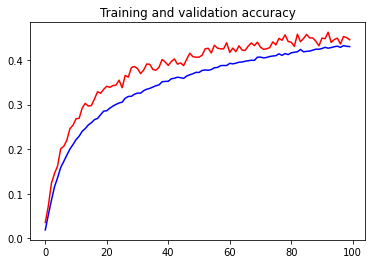

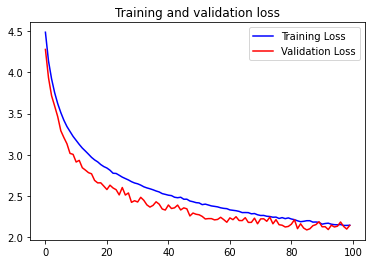

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
model.evaluate(x_test, y_test_oh)

313/313 [==============================] - 1s 3ms/step - loss: 2.0788 - accuracy: 0.4580


[2.078796863555908, 0.4580000042915344]